In [1]:
#install libs
import pandas as pd
import numpy as np
from datetime import datetime
import yfinance as yf
import math
import matplotlib.pyplot as plt

In [24]:
#Average True Range caluclation
def Supertrend(df, atr_period, multiplier):
    
    high = df['High']
    low = df['Low']
    close = df['Close']
    price_diffs = [high - low, 
                   high - close.shift(), 
                   close.shift() - low]
    true_range = pd.concat(price_diffs, axis=1)
    true_range = true_range.abs().max(axis=1)
    # default ATR calculation in supertrend indicator
    atr = true_range.ewm(alpha=1/atr_period,min_periods=atr_period).mean()     
    hl2 = (high + low) / 2
    final_upperband = upperband = hl2 + (multiplier * atr)
    final_lowerband = lowerband = hl2 - (multiplier * atr)
    
    supertrend = [True] * len(df)
    
    for i in range(1, len(df.index)):
        curr, prev = i, i-1
        if close[curr] > final_upperband[prev]:
            supertrend[curr] = True
        elif close[curr] < final_lowerband[prev]:
            supertrend[curr] = False
        else:
            supertrend[curr] = supertrend[prev]
            
            if supertrend[curr] == True and final_lowerband[curr] < final_lowerband[prev]:
                final_lowerband[curr] = final_lowerband[prev]
            if supertrend[curr] == False and final_upperband[curr] > final_upperband[prev]:
                final_upperband[curr] = final_upperband[prev]

        if supertrend[curr] == True:
            final_upperband[curr] = np.nan
        else:
            final_lowerband[curr] = np.nan
    
    return pd.DataFrame({
        'Supertrend': supertrend,
        'Final Lowerband': final_lowerband,
        'Final Upperband': final_upperband
    }, index=df.index)
    
    
atr_period = 10
atr_multiplier = 3.0

stock_list = ['AAPL']
for symbol in stock_list:
    df = yf.download(symbol, start='2022-01-01')
    supertrend = Supertrend(df, atr_period, atr_multiplier)
    df = df.join(supertrend)
df.tail(15)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Supertrend,Final Lowerband,Final Upperband
Date,,,,,,,,,
2022-03-21,163.509995,166.350006,163.009995,165.380005,165.380005,95811400,False,NaN,167.529294
2022-03-22,165.509995,169.419998,164.910004,168.820007,168.820007,81532000,True,152.824902,NaN
2022-03-23,167.990005,172.639999,167.649994,170.210007,170.210007,98062700,True,155.741751,NaN
2022-03-24,171.059998,174.139999,170.210007,174.070007,174.070007,90131400,True,158.033665,NaN
2022-03-25,173.880005,175.279999,172.750000,174.720001,174.720001,80546200,True,160.530106,NaN
2022-03-28,172.169998,175.729996,172.000000,175.600006,175.600006,90371900,True,160.610008,NaN
2022-03-29,176.690002,179.009995,176.339996,178.960007,178.960007,100589400,True,164.722998,NaN
2022-03-30,178.550003,179.610001,176.699997,177.770004,177.770004,92633200,True,165.625816,NaN
2022-03-31,177.839996,178.029999,174.399994,174.610001,174.610001,103049300,True,165.625816,NaN


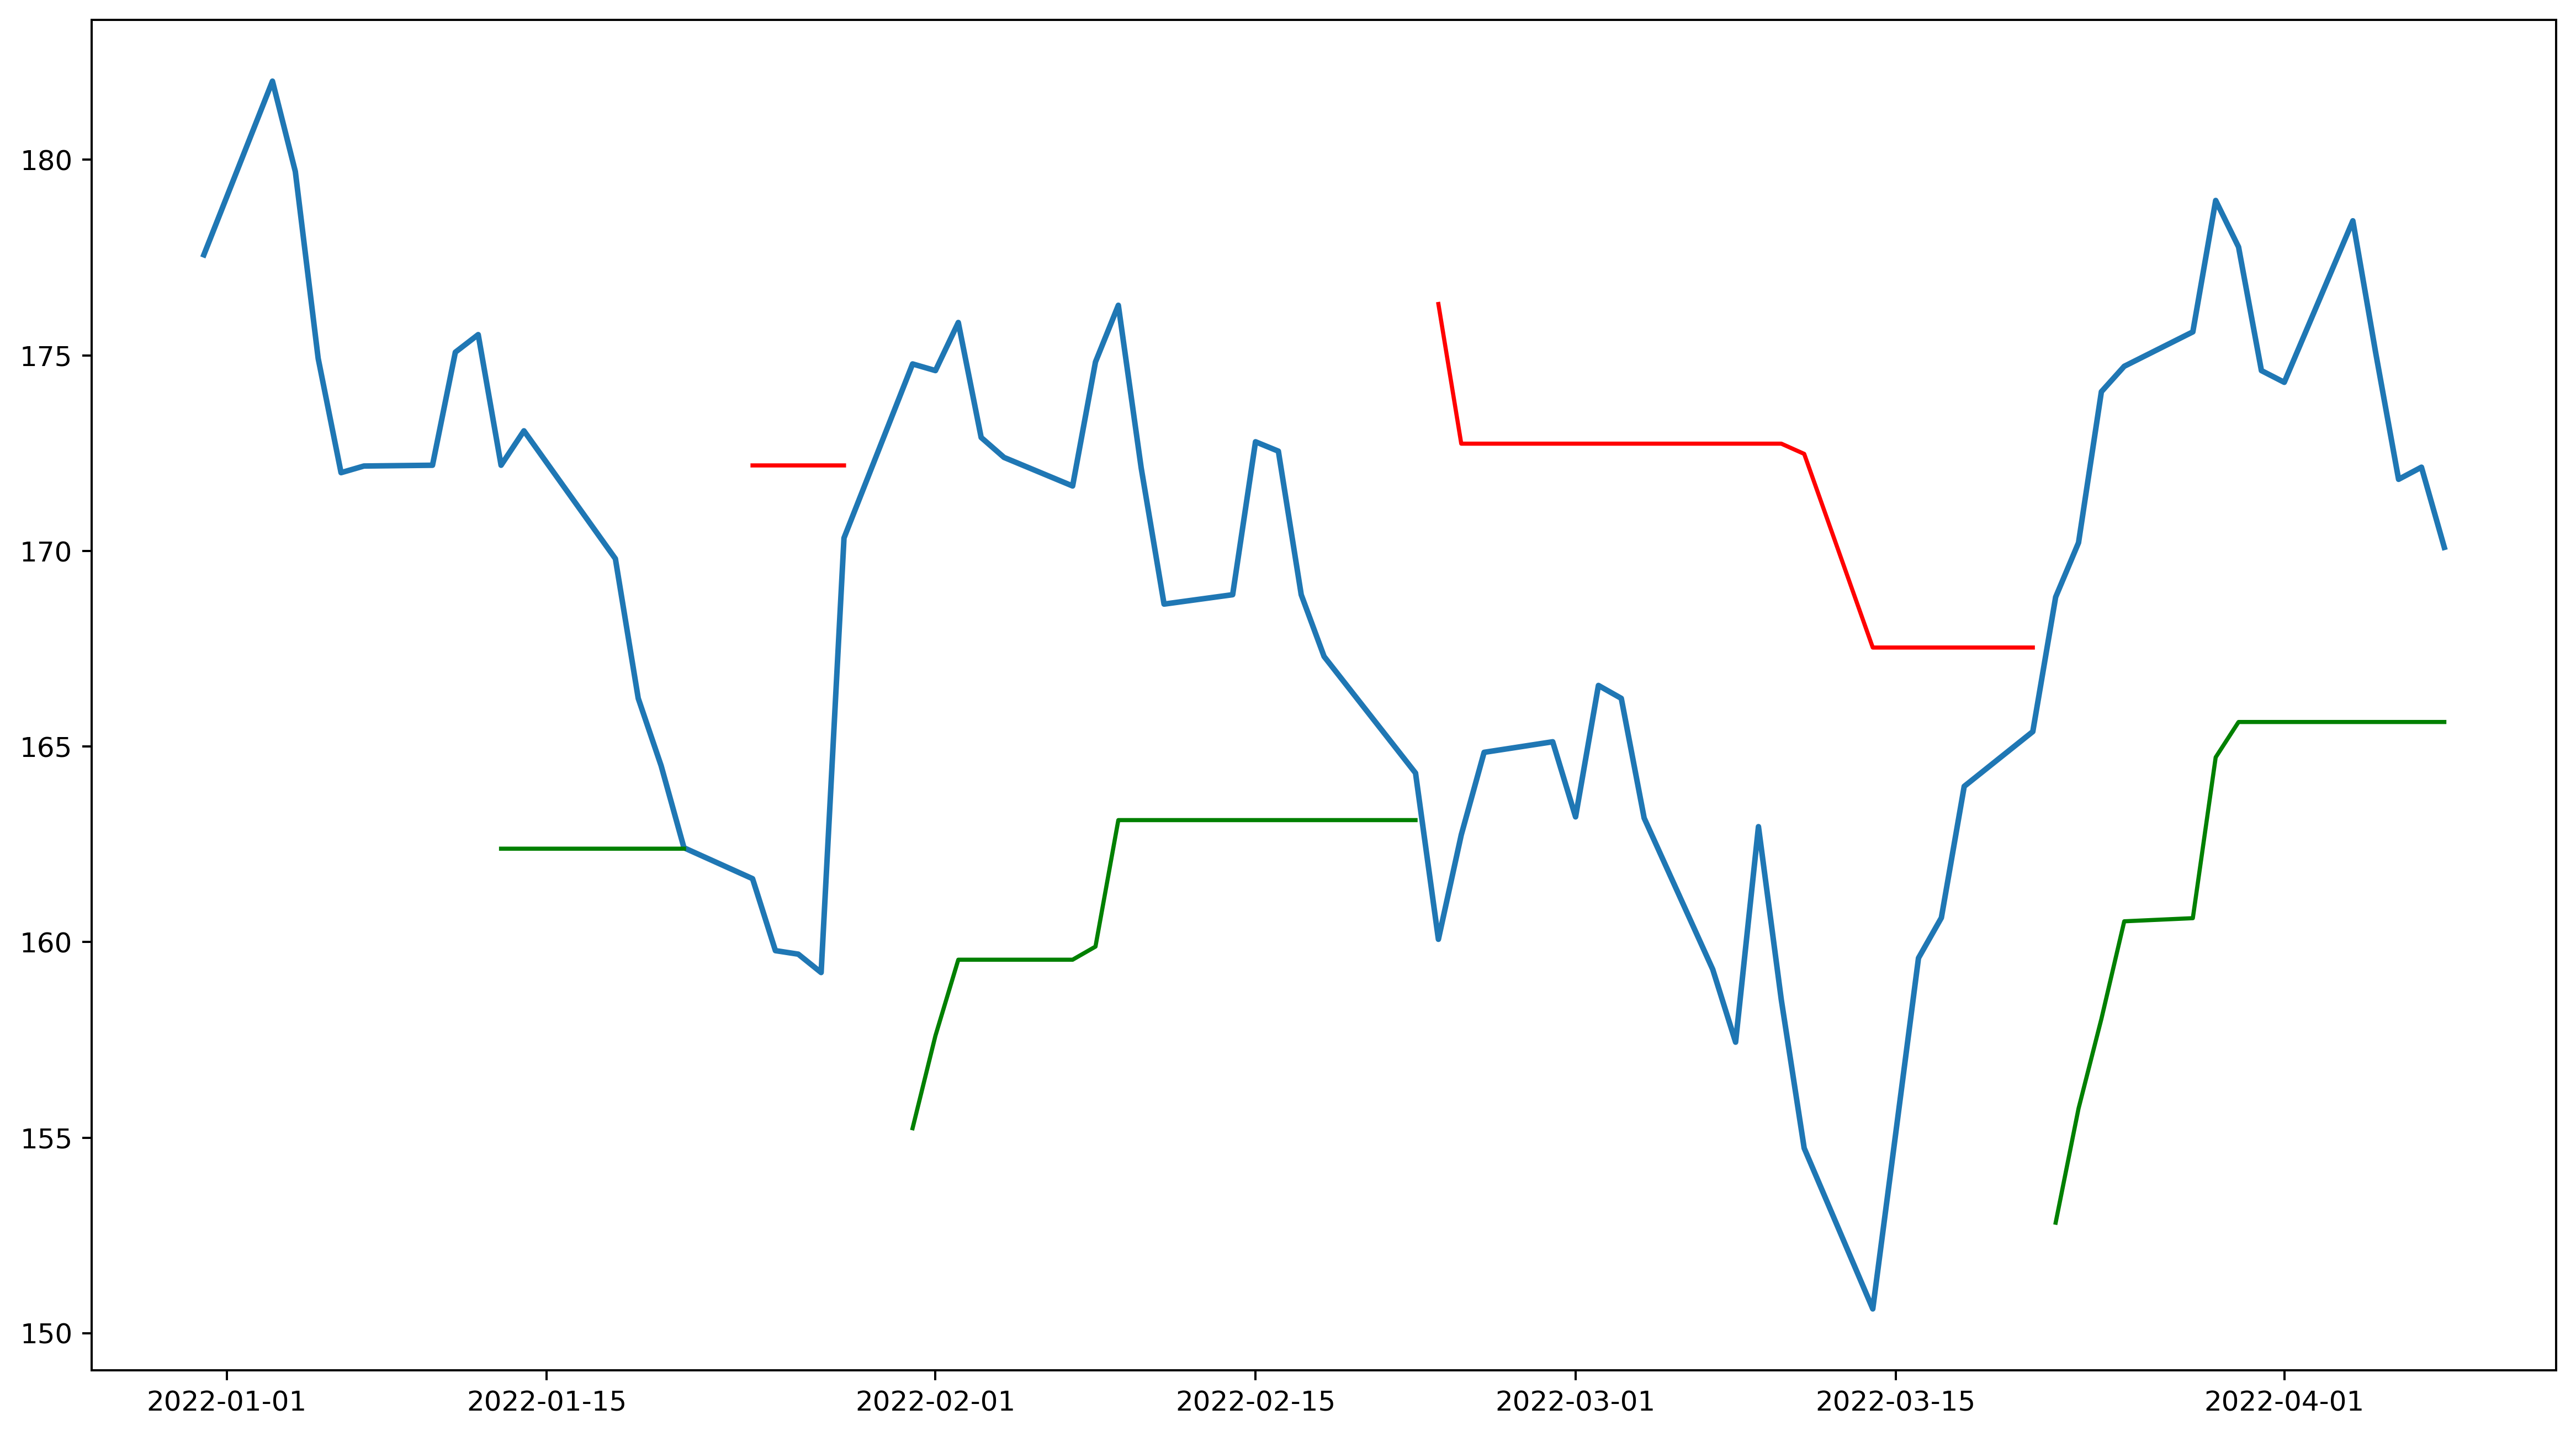

In [25]:
#vizualizing graphs
plt.figure(figsize=(16,9),dpi=360)
plt.plot(df['Close'], linewidth = 2, label='Close Price')
plt.plot(df['Final Lowerband'],'g', label = 'Final Lowerband')
plt.plot(df['Final Upperband'], 'r', label = 'Final Upperband')
plt.show()

In [26]:
#backtetsing
def backtest_supertrend(df, investment):
    is_uptrend = df['Supertrend']
    close = df['Close']
    
    # initial condition
    in_position = False
    equity = investment
    commission = 5
    share = 0
    entry = []
    exit = []
    for i in range(2, len(df)):
        if not in_position and is_uptrend[i]:
            share = math.floor(equity / close[i] / 100) * 100
            equity -= share * close[i]
            entry.append((i, close[i]))
            in_position = True
        elif in_position and not is_uptrend[i]:
            equity += share * close[i] - commission
            exit.append((i, close[i]))
            in_position = False
    if in_position:
        equity += share * close[i] - commission
    earning = equity - investment
    roi = round(earning/investment*100,2)
    print(f'Earning from investing $100k is ${round(earning,2)} (ROI = {roi}%)')
    return entry, exit, roi
entry, exit, roi = backtest_supertrend(df, 100000)

Earning from investing $100k is $-15902.0 (ROI = -15.9%)


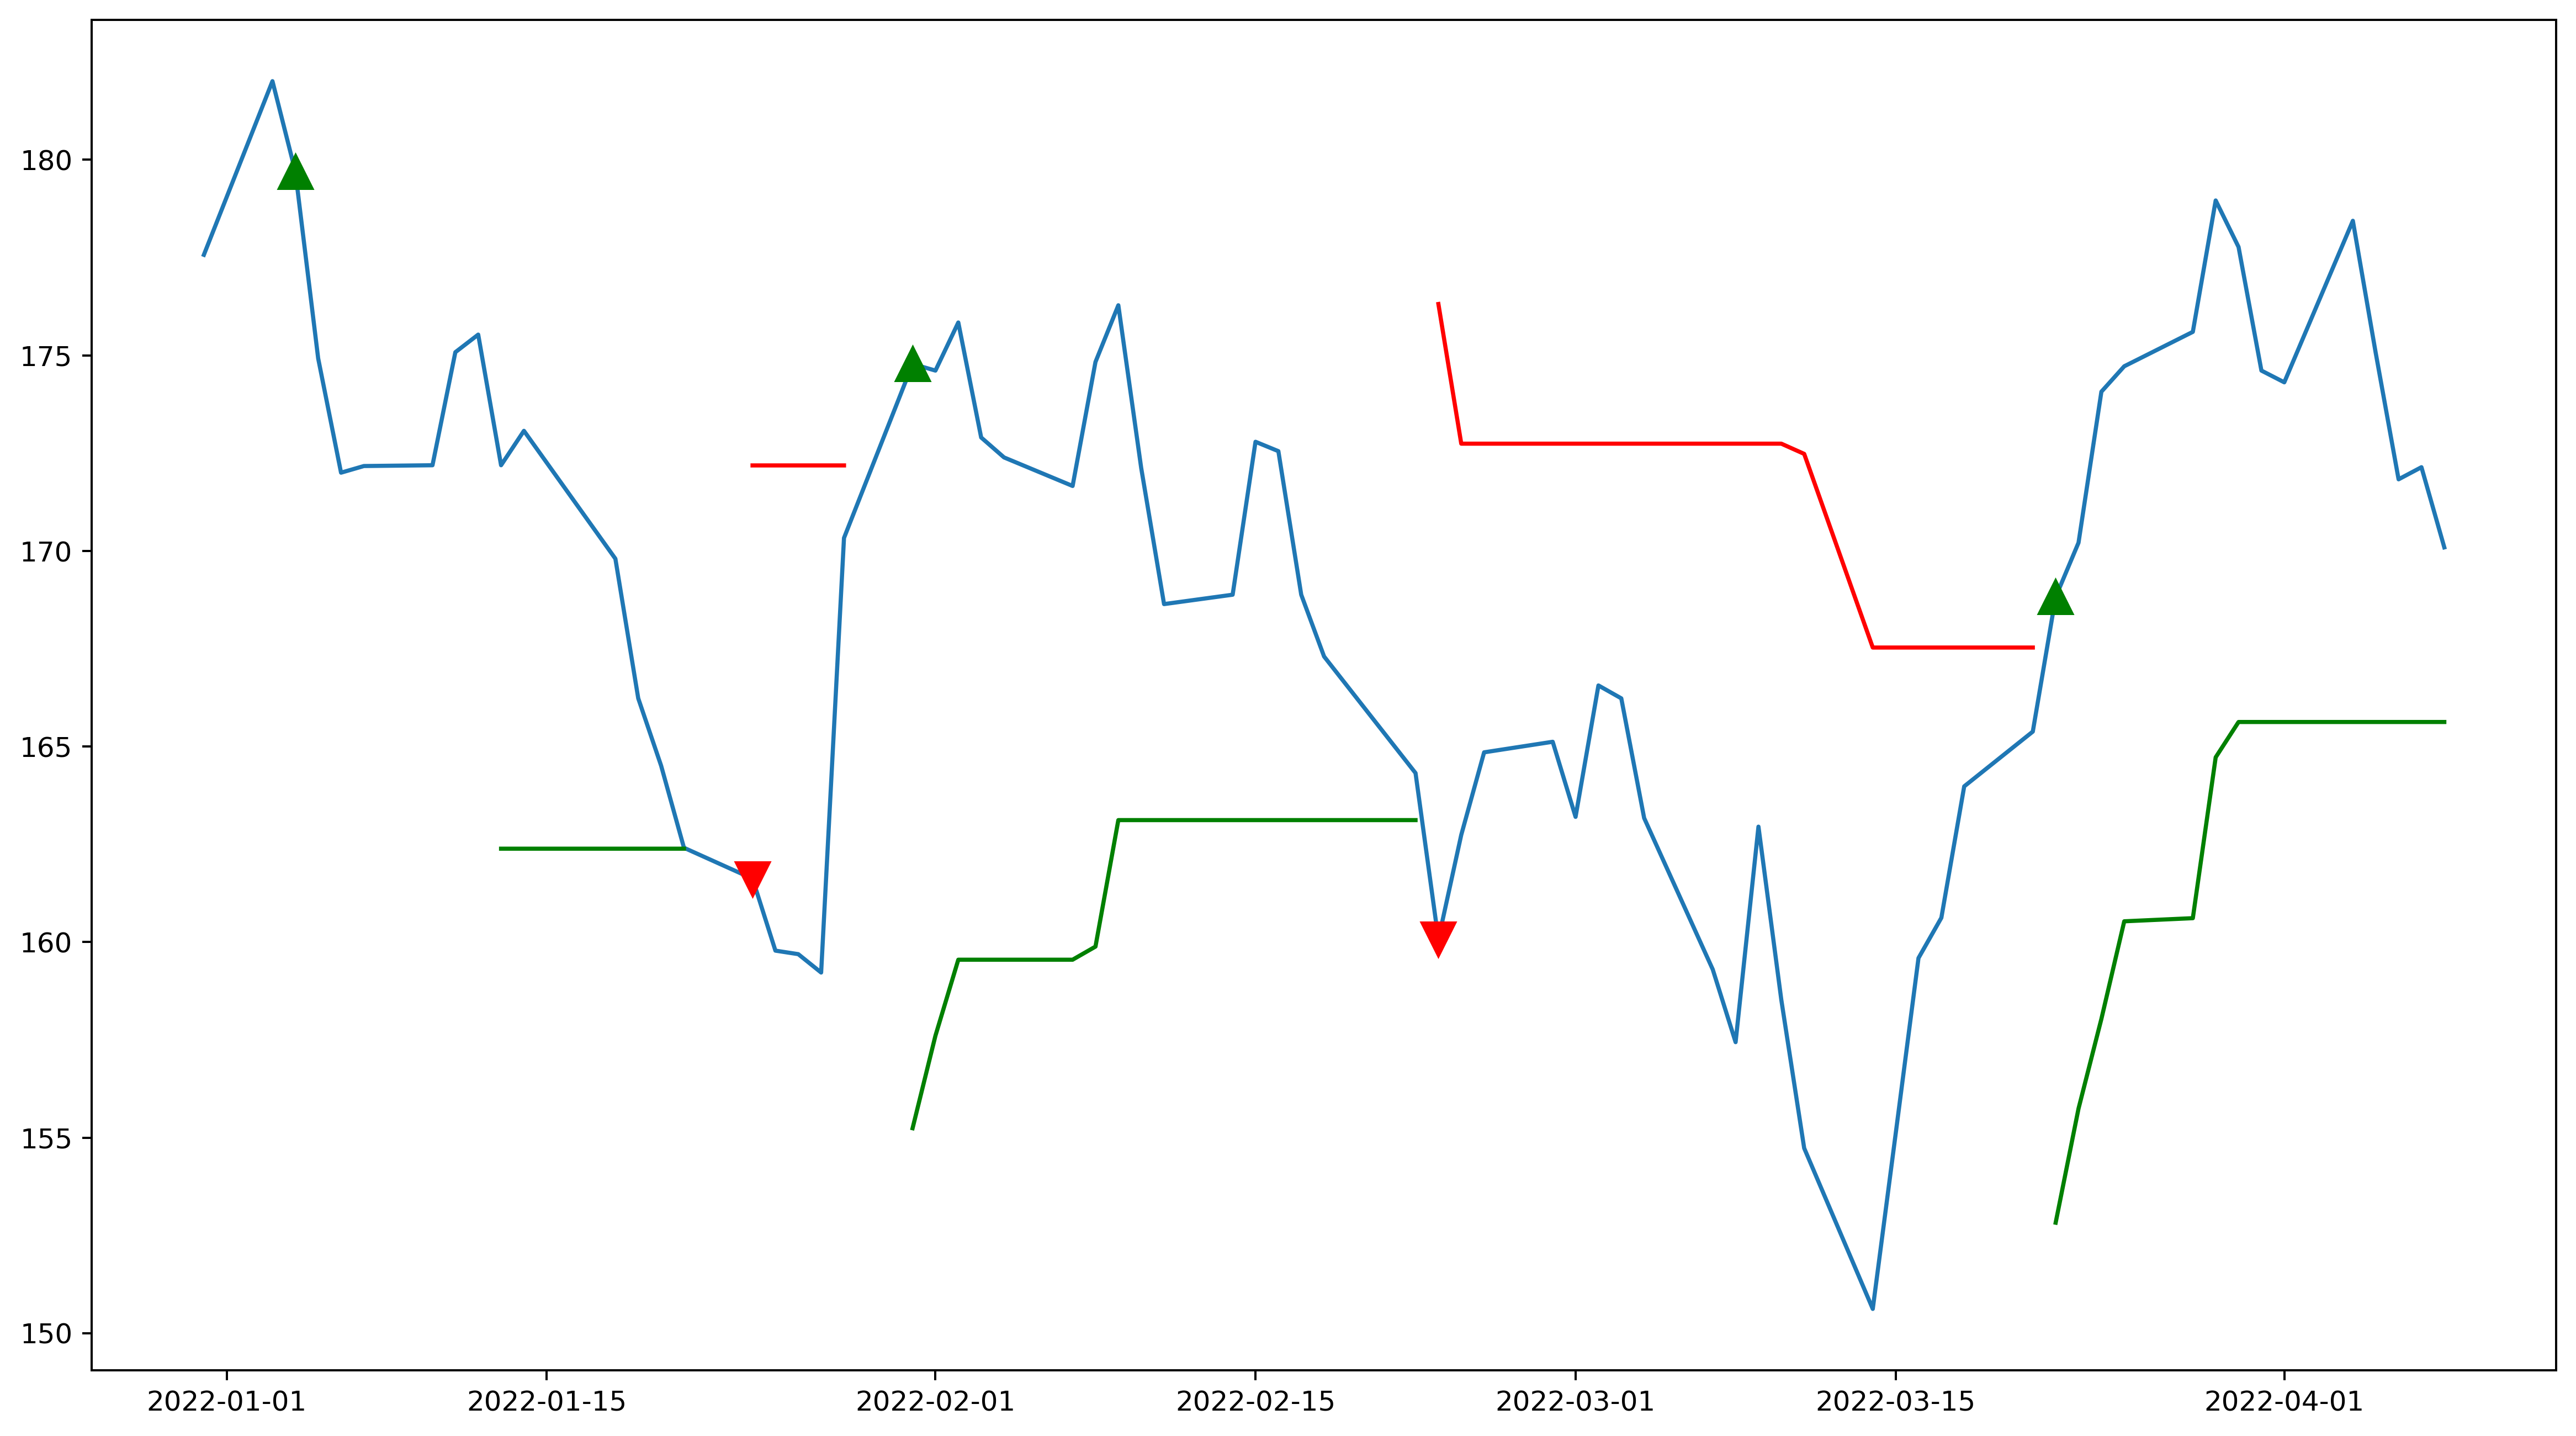

In [27]:
#vizualising backtesting
plt.figure(figsize=(16,9),dpi=360)
plt.plot(df['Close'], label='Close Price')
plt.plot(df['Final Lowerband'],'g', label = 'Final Lowerband')
plt.plot(df['Final Upperband'], 'r', label = 'Final Upperband')
for e in entry:
    plt.plot(df.index[e[0]], e[1], marker = '^', color = 'green', markersize = 12, linewidth = 0, label = 'Entry')
for e in exit:
    plt.plot(df.index[e[0]], e[1], marker = 'v', color = 'red', markersize = 12, linewidth = 0, label = 'Exit')
plt.show()


In [22]:
#getting fulllist of stock s&p 500
payload = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
stock_list = payload[0]['Symbol'].values.tolist()

supertrend_stocks = []
for symbol in stock_list:
    df = yf.download(symbol, start='2022-01-01', threads= False)
    if len(df) == 0: continue
    supertrend = Supertrend(df, atr_period, atr_multiplier)
    if not supertrend['Supertrend'][-2] and supertrend['Supertrend'][-1]:
        supertrend_stocks.append(symbol)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [28]:
for s in supertrend_stocks:
    print(s, end=', ')

AAP, DVA, GPC, GILD, NRG, SJM, VZ, ZTS, 

In [29]:
# BONUS: parameter optimization
def find_optimal_parameter(df):
    atr_period = [7, 8, 9, 10]
    atr_multiplier = [1.0, 1.5, 2.0, 2.5, 3.0]

    roi_list = []
    
    for period, multiplier in [(x,y) for x in atr_period for y in atr_multiplier]:
        new_df = df
        supertrend = Supertrend(df, period, multiplier)
        new_df = df.join(supertrend)
        new_df = new_df[period:]
        entry, exit, roi = backtest_supertrend(new_df, 100000)
        roi_list.append((period, multiplier, roi))
    
    print(pd.DataFrame(roi_list, columns=['ATR_period','Multiplier','ROI']))
    
    return max(roi_list, key=lambda x:x[2])

df = yf.download('TSLA', start='2010-01-01')
optimal_param = find_optimal_parameter(df)

print(f'Best parameter set: ATR Period={optimal_param[0]}, Multiplier={optimal_param[1]}, ROI={optimal_param[2]}')

[*********************100%***********************]  1 of 1 completed
Earning from investing $100k is $1488652.26 (ROI = 1488.65%)
Earning from investing $100k is $1171297.56 (ROI = 1171.3%)
Earning from investing $100k is $2001068.51 (ROI = 2001.07%)
Earning from investing $100k is $5789457.28 (ROI = 5789.46%)
Earning from investing $100k is $2514654.57 (ROI = 2514.65%)
Earning from investing $100k is $1090075.61 (ROI = 1090.08%)
Earning from investing $100k is $879621.24 (ROI = 879.62%)
Earning from investing $100k is $1976029.15 (ROI = 1976.03%)
Earning from investing $100k is $4449959.97 (ROI = 4449.96%)
Earning from investing $100k is $2455046.98 (ROI = 2455.05%)
Earning from investing $100k is $993379.62 (ROI = 993.38%)
Earning from investing $100k is $890991.24 (ROI = 890.99%)
Earning from investing $100k is $1767935.35 (ROI = 1767.94%)
Earning from investing $100k is $3533388.69 (ROI = 3533.39%)
Earning from investing $100k is $2869008.59 (ROI = 2869.01%)
Earning from investing 